In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from celluloid import Camera
import networkx as nx
import time

import tensorflow as tf
from tensorflow import keras

%matplotlib notebook

In [2]:
class Distributed_System():
    def __init__(self, N, L):
        np.random.seed(42)
        self.N = N
        self.L = L
        
        # Variables: x , y (positions of agents in plan)
        self.x = np.random.rand(N)*L           # Initialize xᵢ
        self.y = np.random.rand(N)*L           # Initialize yᵢ
        
        
        self.r = np.ones(N)                    # Wave sending radius
        self.A = np.zeros((N,N))               # Adjacency Matrix
        self.k = np.zeros(N)                   # Degree of a vertex
        for i in range(N):
            for j in range(i+1,N):
                if ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 < self.r[i]:
                    self.A[i][j] = self.A[j][i] = 1
                    self.k[i]   += self.A[i][j]
                    self.k[j]   += self.A[i][j]
                    
        
        
    def step(self, r):
        Hamilton_t0 = np.zeros(self.N)
        Hamilton_t1 = np.zeros(self.N)
        for i in range(self.N):
            Hamilton_t0[i], e = self.Hamiltonian(i)    ###
        
        self.r   += (r-1)*(0.25*self.L**2/self.N)*np.random.rand()
        self.A    = np.zeros((N,N))
        self.k    = np.zeros(N)
        mean_r_ij = np.zeros((N))
        
        for i in range(self.N):
            if self.r[i] < 0:      self.r[i] = 0
            if self.r[i] > self.L: self.r[i] = self.L
        
        for i in range(self.N):
            for j in range(i+1, self.N):
                distance = ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5
                if distance < self.r[i] or distance < self.r[j]:
                    self.A[i][j] = self.A[j][i] = 1;
                    self.k[i]   += self.A[i][j]
                    self.k[j]   += self.A[i][j]

                    mean_r_ij[i] += distance
                    mean_r_ij[j] += distance
        
        for i in range(self.N):
            Hamilton_t1[i], e = self.Hamiltonian(i)    ###
        reward = Hamilton_t0 - Hamilton_t1
        return ([ self.k, self.r, mean_r_ij/(self.k+1e-10) ], reward)
        
        
    def Hamiltonian(self, i):
        alfa_1 = -0.5
        alfa_2 = +0.05
        alfa_3 = +0.2
        alfa_4 = -0.5
        
        fourth = np.zeros(self.N)
        for j in range(self.N):
            if i != j:
                fourth[i] += (self.A[i][j] / (( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 ))
            
        H = alfa_1*self.k[i]**2 + alfa_2*self.k[i]**3 + alfa_3*self.r[i]**2 + alfa_4*fourth[i]
        return H, fourth[i]                ###
    
    

    def Plot(self, episode):                ###
        options = { 'node_size': 60, 'width': 0.3 }
        
        G = nx.from_numpy_array(self.A)
        for i in range(self.N):
            G.add_node(i, pos=(self.x[i], self.y[i]))
        pos = nx.get_node_attributes(G,'pos')
        
        nx.draw_networkx(G, pos, with_labels=False, **options)
        
        plt.text(self.L-0.15*self.L, self.L+0.3, f'Episode {episode}', fontname='Comic Sans MS', fontsize=12)        ###
        plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.xlim(-0.1, self.L+0.1); plt.ylim(-0.1, self.L+0.1)
        plt.grid(alpha = 0.3)
        camera.snap()
#         plt.show()

In [3]:
N = 25                    # Number of agents
L = 5                     # The length of the simulation box

env = Distributed_System(N,L)

In [4]:
tf.random.set_seed(42)
np.random.seed(42)

input_shape = [3]              # == env.observation_space.shape
n_outputs = 3                  # == env.action_space.n

model = []
for i in range(N):
    model.append(keras.models.Sequential([
        keras.layers.Dense(10, activation="elu", input_shape=input_shape),
        keras.layers.Dense(10, activation="elu"),
        keras.layers.Dense(n_outputs)
    ]))

In [5]:
replay_memory = []
for i in range(N):
    replay_memory.append(deque(maxlen=800))

def play_one_step(env, state, epsilon=0):
    action = np.zeros(N)

    for i in range(N):
        if np.random.rand() < epsilon:
            action[i] = np.random.randint(n_outputs)
        else:
            actionnnn = model[i].predict(np.reshape(state[i], (3)).reshape(1, -1), verbose=0)[0]
            action[i] = np.argmax(actionnnn)
    
    next_state, reward = env.step(action)
    next_state = [[next_state[j][i] for j in range(3)] for i in range(N)]
    
    for i in range(N):
        replay_memory[i].append((state[i], action[i], reward[i], next_state[i]))
    return next_state, reward

In [7]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.legacy.Adam(learning_rate=1e-2)
loss_fn   = keras.losses.mean_squared_error

def training_step(i, batch_size):
    indices = np.random.randint(len(replay_memory[i]), size=batch_size)   # 32ta random number between[0 - len(replay)]
    batch   = [replay_memory[i][index] for index in indices]              # number in replay_memory[indices]
    
    states, actions, rewards, next_states = [                             # from replay_memory read these and save in...
        np.array([experience[field_index] for experience in batch])
        for field_index in range(4)]
            
    next_Q_values   = model[i].predict(next_states, verbose=0)      # 32 predict of 2 actions
    max_next_Q_values = np.max(next_Q_values, axis=1)               # choose higher probiblity of each actions (of each 32)
    target_Q_values = (rewards>0.6)*1. + discount_rate*max_next_Q_values     # Equation 18-5. Q-Learning algorithm
    target_Q_values = target_Q_values.reshape(-1, 1)                         # reshape to (32,1) beacuse of Q_values.shape
        
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model[i](states)
        Q_values = tf.reduce_sum(all_Q_values*mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model[i].trainable_variables)
    optimizer.apply_gradients(zip(grads, model[i].trainable_variables))

<IPython.core.display.Javascript object>


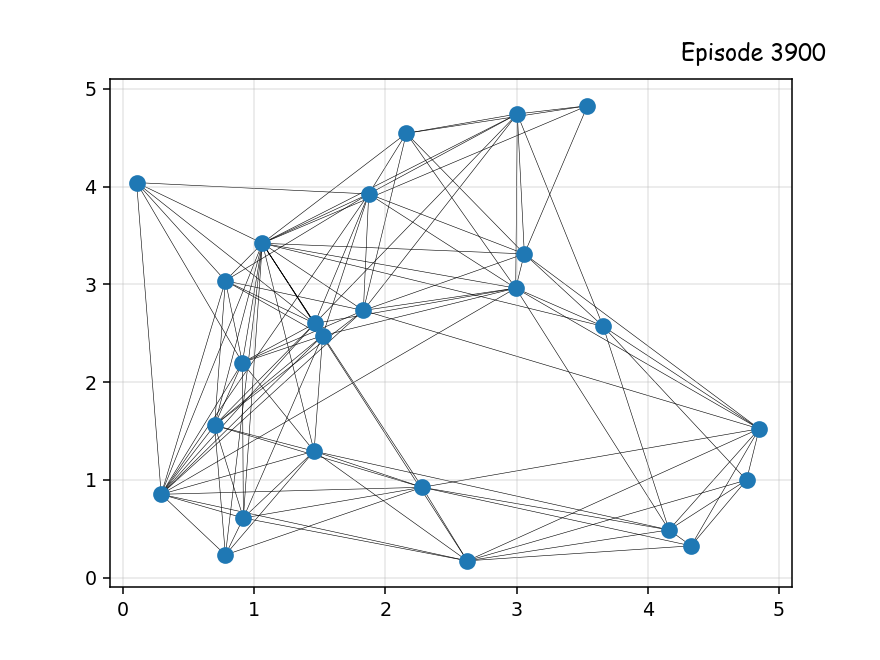

Episode: 21, eps: 0.979, Time One Step: 0.002WARNING:tensorflow:5 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000015F4C00BE20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Episode: 23, eps: 0.977, Time One Step: 0.003WARNING:tensorflow:6 out of the last 7 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000015F4D0559E0> triggered tf.function retracing. Tracing is expensive and the excessive n

In [8]:
env = Distributed_System(N,L)

replay_memory = []
for i in range(N):
    replay_memory.append(deque(maxlen=800))

state, reward = env.step(np.zeros(N))
state = [[state[j][i] for j in range(3)] for i in range(N)]
HH = []

f = open("log_C.txt", "w")
f.write(f"episode \t epsilon \t ")
for i in range(N): f.write(f"r{i} \t ")
for i in range(N): f.write(f"k{i} \t ")
for i in range(N): f.write(f"k{i}**2 \t ")
for i in range(N): f.write(f"k{i}**3 \t ")
for i in range(N): f.write(f"r{i}**2 \t ")
for i in range(N): f.write(f"fourth{i} \t ")
for i in range(N): f.write(f"H{i} \t ")
for i in range(N): f.write(f"reward{i} \t ")
f.write(f"Hamilton \t Time(one_step) \t Time(training) \n")
    

camera = Camera(plt.figure())   
start_total = time.time()
for episode in range(4000):
    Hamilton = 0
    epsilon = max(1 - (episode)/1000, 0.01)            # first is more random and than use greedy
    
    ti_onestep = time.time()                        ### not shown
    state, reward = play_one_step(env, state, epsilon)
    tf_onestep = time.time()                        ### not shown
    
    ti_train = time.time()                          ### not shown
    if episode > 200:
        for i in range(N):
            training_step(i, batch_size)
    tf_train = time.time()                          ### not shown
        
    for i in range(N):                              ###
        Hamilton += env.Hamiltonian(i)[0]           ###
    HH.append(Hamilton)                             ###
      
    if episode%10 == 0:
        env.Plot(episode)
        f.write(f"{episode} \t {epsilon} \t ")
        for i in range(N): f.write(f"{env.r[i]} \t ")
        for i in range(N): f.write(f"{env.k[i]} \t ")
        for i in range(N): f.write(f"{env.k[i]**2} \t ")
        for i in range(N): f.write(f"{env.k[i]**3} \t ")
        for i in range(N): f.write(f"{env.r[i]**2} \t ")
        for i in range(N): f.write(f"{env.Hamiltonian(i)[1]} \t ")
        for i in range(N): f.write(f"{env.Hamiltonian(i)[0]} \t ")
        for i in range(N): f.write(f"{reward[i]} \t ")
        f.write(f"{Hamilton} \t {tf_onestep-ti_onestep} \t {tf_train-ti_train} \n")

    print("\rEpisode: {}, eps: {:.3f}, Time One Step: {:.3f}".format(episode, epsilon, tf_onestep-ti_onestep), end="")
    
    
print(f"\nTotal Time: {time.time() - start_total}")

anim = camera.animate(interval= 100, repeat=True, repeat_delay= 500, blit=True)
anim.save('animation_C.gif')
f.close()

<IPython.core.display.Javascript object>


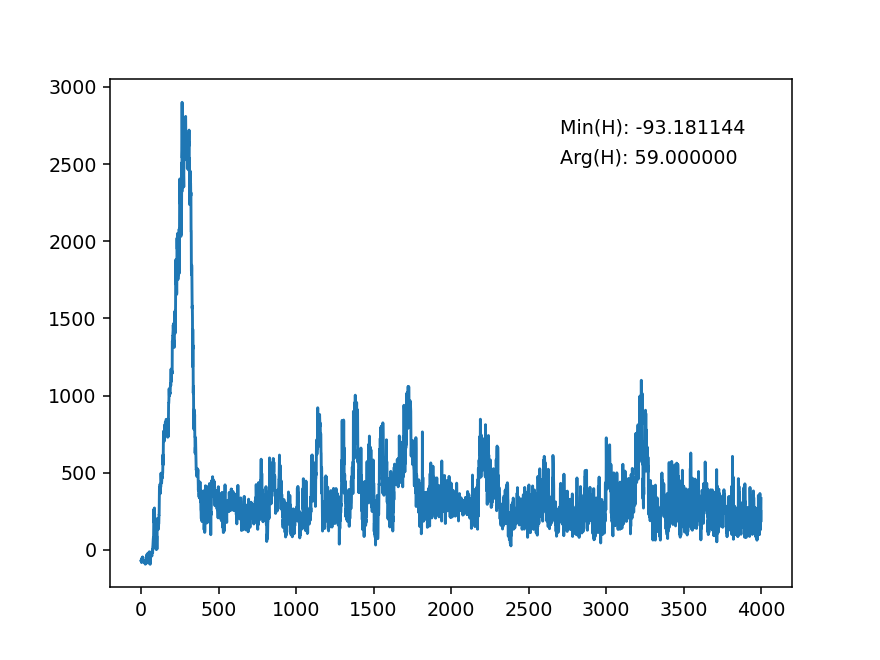

In [13]:
# (rewards>0.6)*1.

plt.plot(HH)
plt.text(2700, max(HH)-200, "Min(H): %f" % (min(HH)) )
plt.text(2700, max(HH)-400, "Arg(H): %f" % (np.argmin(HH)) )
plt.show()

<IPython.core.display.Javascript object>


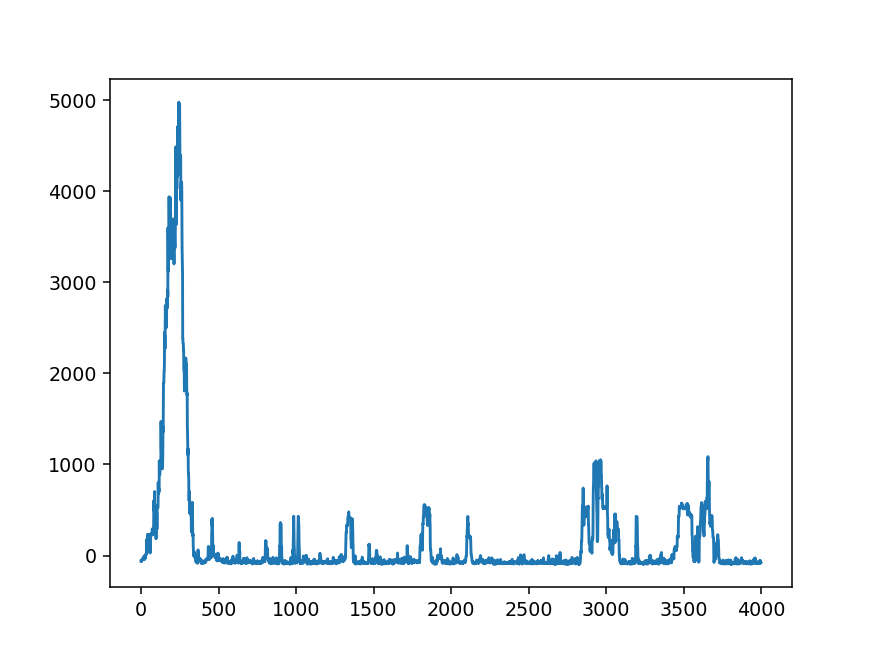

In [20]:
# R = rewards
# for j in range(len(R)):
#     if    R[j] < -0.7: R[j] = -1
#     elif  R[j] > +0.7: R[j] = +1
#     else: R[j] = 0 

plt.plot(HH)
plt.text(2700, 1200, "Min(H): %f" % (min(HH)) )
plt.show()